# Прогнозирование температуры звезды

**Заказчик исследования:** обсерватория «Небо на ладони».

**Задача:** придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики:**

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import warnings
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.optim import Adam 
from phik import phik_matrix
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#Построение графиков и анализ количественных признаков.
def num(column):
    print(column,  '\n')
    print(data[column].describe())
    
    figure, axis = plt.subplots(1, 2, figsize=(13,5))
    
    plt.style.use('bmh')
    
    axis[0].hist(data[column])
    axis[0].set_title('График распределения значений')
    
    axis[1].boxplot(data[column])
    axis[1].set_title('График размаха значений')
    
    figure.suptitle(column)
    plt.show()

In [4]:
#Построение графиков и анализ категориальных признаков.
def cat(column):
    print(column, '\n')
    print(data[column].value_counts())
    
    names = list(data[column].value_counts().index)
    values = list(data[column].value_counts().values)

    figure, axis = plt.subplots(figsize=(5, 5))
    
    axis.barh(names, values)
    
    plt.style.use('bmh')
    
    figure.suptitle(column)
    plt.show()

In [5]:
#Построение графиков по нейронным сетям
def build_graphic():
    figure, axis = plt.subplots(1, 1, figsize=(10,8))
    
    plt.style.use('bmh')

    axis.bar(x = y_test.index, height = y_test.values, width = 3, label = 'Факт')
    axis.bar(x = y_test.index, height = test_preds.int(), width = 5, alpha=0.5, label = 'Прогноз')

    plt.xlabel("Номер звезды в таблице данных")
    plt.ylabel("Температура звезды")

    figure.suptitle('График')
    plt.legend()
    plt.show()

## Загрузка данных

In [6]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## Предобработка и анализ данных

### Проверка на дубликаты

In [8]:
data.duplicated().sum()

0

### Анализ количественных признаков

In [9]:
numeric = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

Temperature (K) 

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64


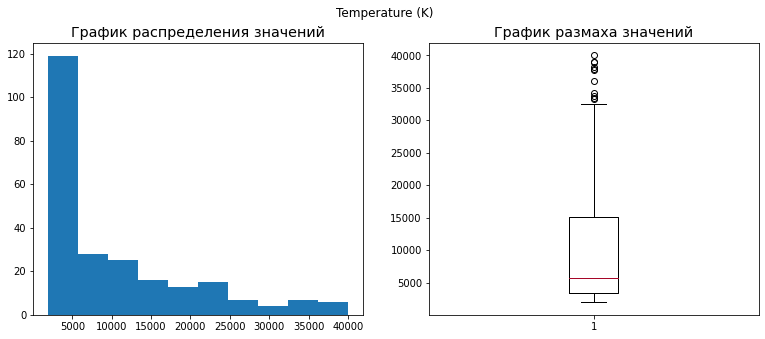

Luminosity(L/Lo) 

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64


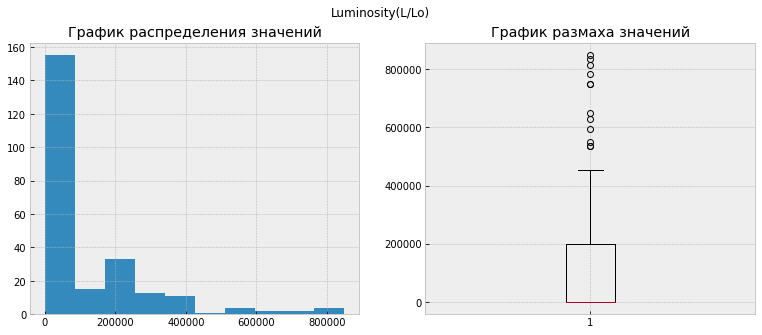

Radius(R/Ro) 

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64


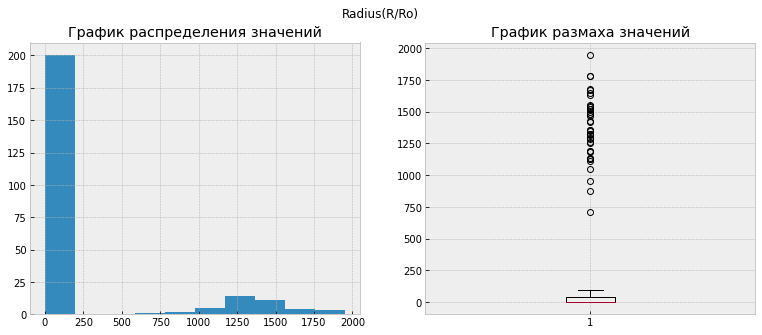

Absolute magnitude(Mv) 

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64


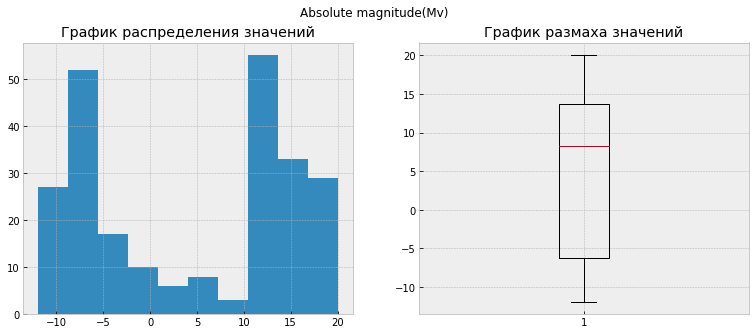

In [10]:
for col in numeric:
    num(col)

In [11]:
# для удобства избавимся от скобок в названиях
data = data.rename(columns={'Temperature (K)': 'temperature', 
                            'Luminosity(L/Lo)': 'luminosity',
                            'Radius(R/Ro)': 'radius',
                            'Absolute magnitude(Mv)': 'absolute_magnitude'})

Данные с температурой распределены неравномерно, но т.к. это целевой признак, то лучше ничего там не удалять.

В данных о радиусе большинство значений околонулевых и не превышающих 250, все данные о радиусах, которые превышают 250, относятся к звездам 5 типа.

In [12]:
data.query('radius > 250')

,temperature,luminosity,radius,absolute_magnitude,Star type,Star color
50,3490,270000.0,1520.0,-9.40,5,Red
51,3750,283000.0,1260.0,-7.63,5,Red
52,3834,272000.0,1183.0,-9.20,5,Red
53,3749,550000.0,1648.0,-8.05,5,Orange
54,3650,310000.0,1324.0,-7.79,5,Red
55,3450,263000.0,1349.0,-11.75,5,Red
56,3660,363000.0,1673.0,-11.92,5,Red
57,3450,174000.0,1284.0,-11.28,5,Red
58,3752,209000.0,955.0,-11.24,5,Red
59,3535,195000.0,1546.0,-11.36,5,Red


В данных о светимости тоже много выбросов, но их удаление может негативно сказаться на обучении нейросети, поэтому оставим как есть.

Значения абсолютной магнитуды выбросов не имеют, менять не надо.

### Анализ категориальных признаков

In [13]:
categorical = ['Star type', 'Star color']

Star type 

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64


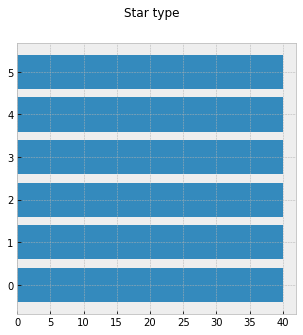

Star color 

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
Yellowish               1
Pale yellow orange      1
Blue                    1
White-Yellow            1
Blue white              1
Blue-White              1
Orange-Red              1
Name: Star color, dtype: int64


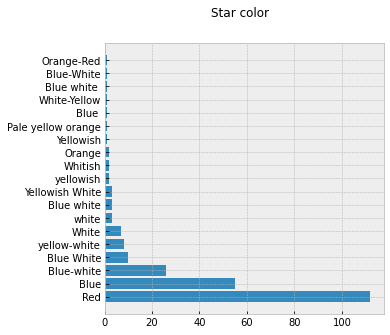

In [14]:
for col in categorical:
    cat(col)

В данных одинаковое количество звёзд каждого типа. В данных о цвете звезд присутствуют неявные дубликаты. Поправим их согласно Гравардской классификации.

In [15]:
# приведем название столбцов к стандартному
data = data.rename(columns={'Star type': 'star_type', 
                            'Star color': 'star_color'})

In [16]:
# изучим значения цветов
data['star_color'].unique() 

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [17]:
data['star_color'] = data['star_color'].str.lower().str.strip()

In [18]:
data['star_color'].unique() 

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

In [19]:
# оставим только основные цвета
data['star_color'] = data['star_color'].replace({'blue white': 'white-blue',
                                                'yellowish white': 'yellow-white',
                                                'pale yellow orange': 'orange',
                                                'blue-white': 'white-blue',
                                                'whitish': 'white',
                                                'yellow-white': 'yellow-white',
                                                'white-yellow': 'yellow-white',
                                                'yellowish': 'yellow',
                                                'orange-red': 'red'})

In [20]:
data['star_color'].unique() 

array(['red', 'white-blue', 'white', 'yellow-white', 'orange', 'blue',
       'yellow'], dtype=object)

Данные привели в порядке теперь посмотрим на их расперделение.

In [21]:
categorical = ['star_type', 'star_color']

star_type 

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64


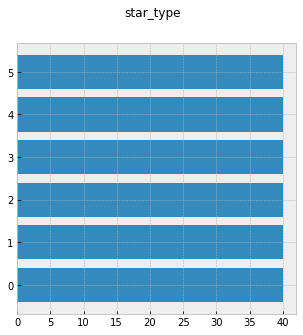

star_color 

red             113
blue             56
white-blue       41
yellow-white     12
white            12
yellow            3
orange            3
Name: star_color, dtype: int64


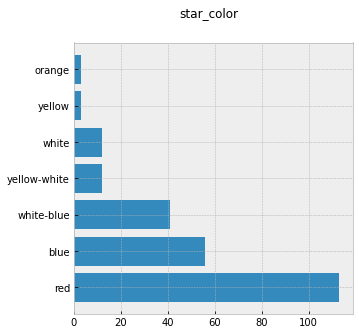

In [22]:
for col in categorical:
    cat(col)

В данных одинаковое количество звёзд каждого типа. Преобладает красный цвет.

**Выводы к обработке данных:**

- Данные от выбросов не очищал, т.к. есть распределение по типу звезд, которое является равномерным;
- Звёзды каждого типа представлены равномерно;
- Названия цветов приведены к единому формату;
- Больше всего звёзд красного цвета.

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type']


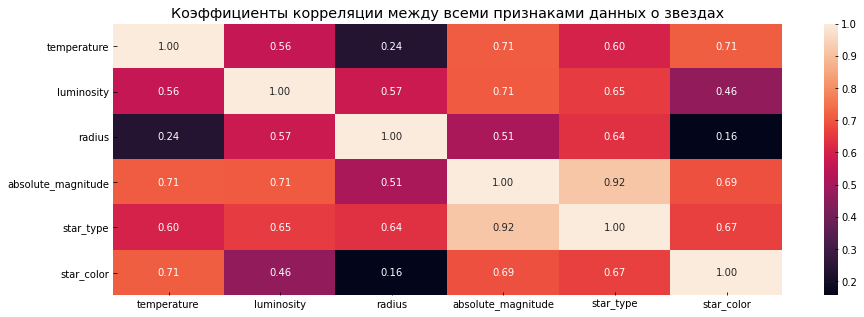

In [23]:
_phik_matrix = data.phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных о звездах');

## Построение базовой нейронной сети

### Подготовка данных к построению модели

In [24]:
features = data.drop('temperature', axis=1)
target = data['temperature']

In [25]:
#КОД РЕВЬЮЕРА
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True, stratify=features['star_color'])

In [26]:
numeric = ['luminosity', 'radius', 'absolute_magnitude']

In [27]:
# кодирование категориальных признаков
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_encoder.fit(X_train[categorical])
X_train_encoded = pd.DataFrame(
    ohe_encoder.transform(X_train[categorical]),
    columns=ohe_encoder.get_feature_names_out(categorical)
)

X_train_ohe = pd.concat((X_train[numeric].reset_index(drop=True), X_train_encoded.reset_index(drop=True)), axis=1)

X_test_encoded = pd.DataFrame(
    ohe_encoder.transform(X_test[categorical]),
    columns=ohe_encoder.get_feature_names_out(categorical)
)

X_test_ohe = pd.concat((X_test[numeric].reset_index(drop=True), X_test_encoded.reset_index(drop=True)), axis=1)

In [28]:
# стандартизация числовых признаков
scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])

X_train_ohe[numeric] = scaler.transform(X_train_ohe[numeric])
X_test_ohe[numeric] = scaler.transform(X_test_ohe[numeric])

In [29]:
X_train_tensor = torch.from_numpy(np.array(X_train_ohe)).float()
X_test_tensor = torch.from_numpy(np.array(X_test_ohe)).float()

y_train_tensor = torch.from_numpy(np.array(y_train)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float()

### Базовая нейронная сеть

In [30]:
# функция активации
def linear(x):
    k = 2
    return k*x

**Архитектура базовой сети:**

- полносвязная сеть прямого распространения
- 2 скрытых слоя
- функция активации для скрытых слоёв - leaky ReLU
- функция активации выходного слоя - линейная

In [31]:
class Basic_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Basic_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [32]:
# инициализация весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [33]:
# гиперпараметры нейросети
num_epochs = 6000
batch_size = 100
accumulation_iteration = 5
num_batches = ceil(len(X_train_tensor)/batch_size)
loss = torch.nn.MSELoss()
learning_rate = 0.01

- Входной слой - 12 нейронов
- Скрытые слои - 3 нейрона
- Выходной слой - 1 нейрон

In [34]:
n_in_neurons = X_train_tensor.size(dim=1)
n_out_neurons = 1
n_hidden_neurons_1 = round(np.sqrt(n_in_neurons))
n_hidden_neurons_2 = round(np.sqrt(n_in_neurons))

In [35]:
basic_net = Basic_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
basic_net.apply(init_weights)
optimizer = torch.optim.Adam(basic_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = basic_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            basic_net.eval()
            test_preds = basic_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')

Эпоха: 0, Loss: 216537456.0, RMSE: 10534.796875
Эпоха: 0, Loss: 231214720.0, RMSE: 10534.5986328125
Эпоха: 100, Loss: 187333536.0, RMSE: 10259.826171875
Эпоха: 100, Loss: 247410752.0, RMSE: 10251.095703125
Эпоха: 200, Loss: 189952320.0, RMSE: 8155.689453125
Эпоха: 200, Loss: 122913472.0, RMSE: 8124.71484375
Эпоха: 300, Loss: 67959584.0, RMSE: 6025.9580078125
Эпоха: 300, Loss: 102519344.0, RMSE: 6017.10205078125
Эпоха: 400, Loss: 49318196.0, RMSE: 5685.2060546875
Эпоха: 400, Loss: 77779520.0, RMSE: 5683.6962890625
Эпоха: 500, Loss: 56666500.0, RMSE: 5563.28173828125
Эпоха: 500, Loss: 54548708.0, RMSE: 5563.1357421875
Эпоха: 600, Loss: 59704152.0, RMSE: 5495.03759765625
Эпоха: 600, Loss: 40682852.0, RMSE: 5494.6640625
Эпоха: 700, Loss: 52733700.0, RMSE: 5423.55859375
Эпоха: 700, Loss: 39355324.0, RMSE: 5422.39111328125
Эпоха: 800, Loss: 40904780.0, RMSE: 5319.1025390625
Эпоха: 800, Loss: 43995160.0, RMSE: 5318.072265625
Эпоха: 900, Loss: 48336360.0, RMSE: 5195.998046875
Эпоха: 900, Loss:

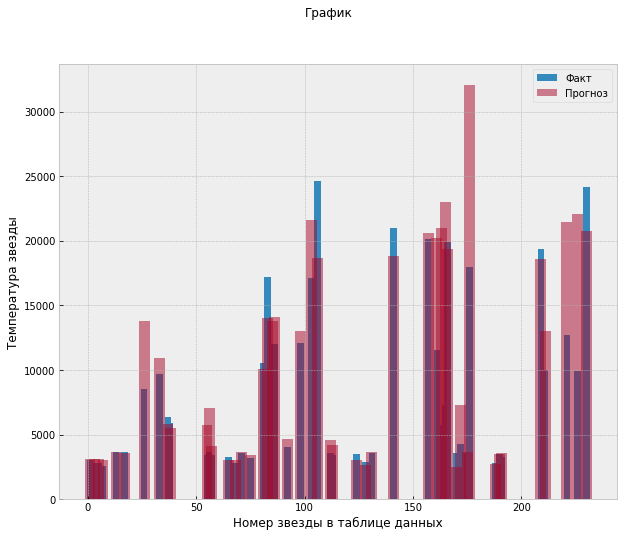

In [36]:
build_graphic()

**Вывод по базовой нейронной сети:**

В целом, нейросеть даёт неплохие результаты. Здесь уже выбраны оптимальное количество эпох, скорость обучения и размер батча.

- Пробовал менять размеры батча 50, 80, 100.
- Скорость обучения 0.0001, 0.1 - слишком маленькая скорость работает медленно, прироста результата не дала. Более высокая скорость пропускает минимумы.
- Количество эпох варьировалось от 100 до 6000 - оставила 6000, т.к. при таком варианте достигается наилучший результат без переобучения.
- Пробовал сначала один скрытый слой - справляется тоже хорошо, но с двумя работает точнее.
- Инициализация весов равномерным/нормальным распределением, fan_in/fan_out - существенных изменений не вносит.
- Функция активации изначально была ReLU, но в данных есть отрицательные значения - решила попробовать leaky ReLU, результат улучшился.
- Наилучшее значение метрики RMSE на тестовой выборке - 4534.

## Улучшение нейронной сети

### BatchNormalization

In [37]:
class BN_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(BN_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [38]:
bn_net = BN_Net(n_in_neurons, n_hidden_neurons_1,  n_hidden_neurons_2, n_out_neurons)
bn_net.apply(init_weights)
optimizer = torch.optim.Adam(bn_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = bn_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            bn_net.eval()
            test_preds = bn_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')

Эпоха: 0, Loss: 248185072.0, RMSE: 10534.4130859375
Эпоха: 0, Loss: 196780672.0, RMSE: 10534.169921875
Эпоха: 100, Loss: 179622384.0, RMSE: 9157.83203125
Эпоха: 100, Loss: 188318496.0, RMSE: 9091.9345703125
Эпоха: 200, Loss: 63136292.0, RMSE: 6028.8984375
Эпоха: 200, Loss: 55992600.0, RMSE: 6026.20703125
Эпоха: 300, Loss: 40434524.0, RMSE: 5277.35498046875
Эпоха: 300, Loss: 38626480.0, RMSE: 5261.939453125
Эпоха: 400, Loss: 18645576.0, RMSE: 4846.63525390625
Эпоха: 400, Loss: 23812144.0, RMSE: 4850.7529296875
Эпоха: 500, Loss: 15069880.0, RMSE: 4391.2421875
Эпоха: 500, Loss: 17931846.0, RMSE: 4384.7890625
Эпоха: 600, Loss: 11697242.0, RMSE: 4298.669921875
Эпоха: 600, Loss: 18079034.0, RMSE: 4297.74365234375
Эпоха: 700, Loss: 16123489.0, RMSE: 4232.19921875
Эпоха: 700, Loss: 11897333.0, RMSE: 4221.47021484375
Эпоха: 800, Loss: 11190111.0, RMSE: 4284.64306640625
Эпоха: 800, Loss: 16483420.0, RMSE: 4279.6806640625
Эпоха: 900, Loss: 15842867.0, RMSE: 4372.7197265625
Эпоха: 900, Loss: 10361

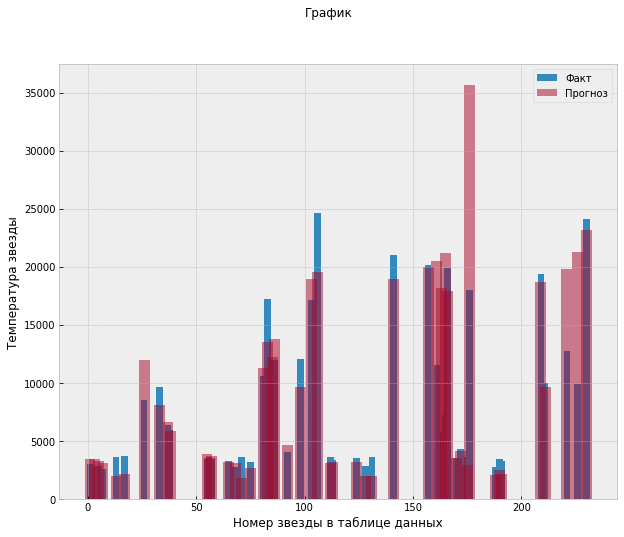

In [39]:
build_graphic()

Лучшее значение метрики RMSE на тестовой выборке - 4270.
Batch Normalization значительно улучшает сходимость обучения. А также при изменении гиперпараметров нейросеть давала более стабильные результаты, чем в других версиях.
Из графика видно следующее:
- у зведзд под номерами от 150 до 250 отклонение по температуре больше, чем от 0 до 150;
- при Batch Normalization сходимость результатов выше, чем у базовой нейронной сети, которая в каждом номерном диапазоне дает примерно одинаковое количество отклонений.

### Dropout

In [40]:
class DP_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(DP_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.8)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.leaky_relu(x)
        x = self.dp1(x)
        x = self.layer2(x)
        x = self.dp2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [41]:
dp_net = DP_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
dp_net.apply(init_weights)
optimizer = torch.optim.Adam(dp_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = dp_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            dp_net.eval()
            test_preds = dp_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')

Эпоха: 0, Loss: 226256704.0, RMSE: 10535.1787109375
Эпоха: 0, Loss: 220640032.0, RMSE: 10535.125
Эпоха: 100, Loss: 210837456.0, RMSE: 10339.619140625
Эпоха: 100, Loss: 225329168.0, RMSE: 10333.068359375
Эпоха: 200, Loss: 181336992.0, RMSE: 8732.9228515625
Эпоха: 200, Loss: 159264480.0, RMSE: 8707.703125
Эпоха: 300, Loss: 93899088.0, RMSE: 6555.54248046875
Эпоха: 300, Loss: 103497248.0, RMSE: 6542.06982421875
Эпоха: 400, Loss: 62344912.0, RMSE: 5821.2470703125
Эпоха: 400, Loss: 72635256.0, RMSE: 5816.1298828125
Эпоха: 500, Loss: 69290944.0, RMSE: 5676.92578125
Эпоха: 500, Loss: 44203608.0, RMSE: 5677.5556640625
Эпоха: 600, Loss: 64752344.0, RMSE: 5468.333984375
Эпоха: 600, Loss: 35926656.0, RMSE: 5471.27001953125
Эпоха: 700, Loss: 46725712.0, RMSE: 5267.59814453125
Эпоха: 700, Loss: 42980720.0, RMSE: 5265.96435546875
Эпоха: 800, Loss: 46294128.0, RMSE: 5134.06640625
Эпоха: 800, Loss: 26889520.0, RMSE: 5132.35595703125
Эпоха: 900, Loss: 32049862.0, RMSE: 4911.87939453125
Эпоха: 900, Loss

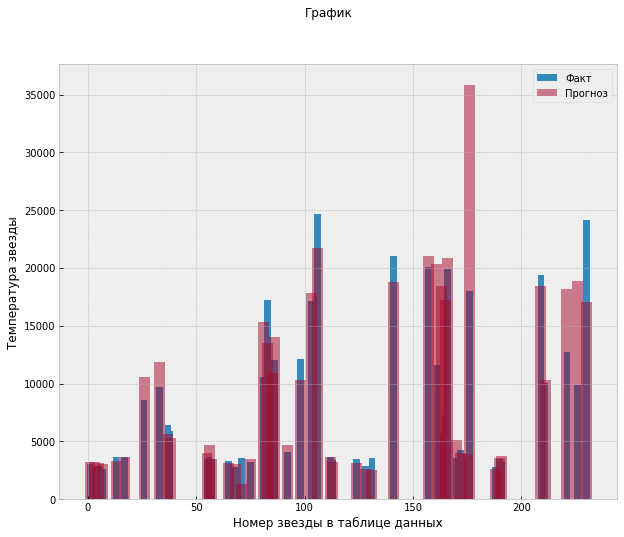

In [42]:
build_graphic()

Лучшее значение метрики RMSE на тестовой выборке - 5046. Было достигнуто на 3400-й эпохе, после чего метрика начала падать. Однако, при каждом новом запуске результаты значительно отличаются. Этот вариант выглядит самым нестабильным из всех.
Из графика видно следующее:
- Dropout хаотично попадает в целевые значения;
- график Dropout намного хуже, чем Batch Normalization, и незначительно хуже, чем базовой нейронной сети. 

## Выводы

После изучения и обработки данных получилось следующее:
- Данные от выбросов не очищал, т.к. есть распределение по типу звезд, которое является равномерным;
- Звёзды каждого типа представлены равномерно;
- Названия цветов приведены к единому формату;
- Больше всего звёзд красного цвета.

В целом, базова нейросеть даёт неплохие результаты. Здесь уже выбраны оптимальное количество эпох, скорость обучения и размер батча.

- Пробовал менять размеры батча 50, 80, 100.
- Скорость обучения 0.0001, 0.1 - слишком маленькая скорость работает медленно, прироста результата не дала. Более высокая скорость пропускает минимумы.
- Количество эпох варьировалось от 100 до 6000 - оставила 6000, т.к. при таком варианте достигается наилучший результат без переобучения.
- Пробовал сначала один скрытый слой - справляется тоже хорошо, но с двумя работает точнее.
- Инициализация весов равномерным/нормальным распределением, fan_in/fan_out - существенных изменений не вносит.
- Функция активации изначально была ReLU, но в данных есть отрицательные значения - решила попробовать leaky ReLU, результат улучшился.
- Наилучшее значение метрики RMSE на тестовой выборке - 4534.

В целом, все 3 модели хорошо справляются с поставленной задачей. Базовая модель обучается медленно, но стабильно, и по ней легче отследить процесс обучения. BatchNorm работает быстрее, использование этой техники кажется предпочтительным (RMSE составляет 4270). Dropout сильно зависит от изменения гиперпараметров и, есть ощущение, что для конкретно этой задачи не очень подходит.